# Part 6: Neural Networks for Classification

In [1]:
import os
import sys
import json
import numpy as np
from scipy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
from mpl_toolkits.mplot3d import Axes3D
from math import log
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
# training image class
class Ti:
    def __init__(self):
        self.img = [] # pixel values
        self.feature = [] # feature vecter
        self.di = [] # dimensionality reduced feature
        self.id = 0 # -1 belongs to me
        self.trans = [] # data transform to new space
        self.prediction = 0 # predicted label only valid for test data
        

In [3]:
# collect all traning set data 
def alldata():
    # load current directory
    cur_dir = os.path.dirname(os.path.abspath("CA2_Part1.ipynb"))
    # PIE directory
    PIE_dir = cur_dir + '/PIE'
    # load json folder
    json_dir = PIE_dir + '/json'
    # read json files' name
    datanames = os.listdir(json_dir)
    datanames.remove('Me')
    datanames.remove('.DS_Store')

    # load all PIE data
    PIE_img = []
    for person in datanames:
        jsonfile = open(json_dir+'/'+person)
        img = json.load(jsonfile)

        # store the image information in class
        for im in img: 
            sample = Ti()
            sample.img = im
            sample.id = int(person)
            PIE_img.append(sample)
            
    # show the id of the data
    ID = []
    for sample in PIE_img:
        ID.append(sample.id)
    person = list(set(ID))
    person = sorted(person)
    print(person)

    ####
    # load my photo data set
    ####
    me_img = []
    jsonfile = open(json_dir+'/Me')
    img = json.load(jsonfile)

    # store the image information in class
    for im in img: 
        sample = Ti()
        sample.img = im
        sample.id = -1
        me_img.append(sample)
        
    return PIE_img, me_img

In [4]:
# select some dubjects in all data
def dataselect(data,num,ID = None):
    
    # input protect
    allID = []
    for sample in data:
        allID.append(sample.id)
    person = list(set(allID))
    
    if ID != None:
        # check inputs
        if len(ID) != num:
            raise ValueError('Input attributes not match!')
        for i in ID:
            if i not in person:
                raise ValueError('Input ID not exist!')
                
    else:
        ID = sorted(random.sample(person,num))
        print('Random selected id is :',ID)
    
    # select data with certain selected id  
    data_set = []
    for sample in data:
        if sample.id in ID:
            data_set.append(sample)
            
    return data_set, ID

In [5]:
# generate num numbers whose total is summary
# least : min value of every number
def sumran(num,summary,least = 1):
#     print(num,summary,least)
    n = num - 1
    loops = 0
    if summary/num < least:
        raise ValueError("input attributes are not resonable")
        
    elif int(summary/num) * 0.95 <= least:
        output = list(np.ones(num) * int(summary/num))
    
    else:
        while True:
            loops += 1
            points = random.sample(range(least,summary - least),n)
            points = sorted(points)
            points = [0] + points + [summary]

            output = []
            for i in range(1,num+1):
                output.append(points[i] - points[i-1])

            if min(output) > least:
                print(output)
                break
            elif loops > 10e8:
                raise ValueError("input attributes are not resonable")
        
    return output

In [6]:
# get training data set and test data set
# ran_num == None : all data will be taken
def dataset(data,ran_per = None,ran_num = None,train_percent = 0.7,least_sample = 10):
    
    ID = []
    for sample in data:
        ID.append(sample.id)
    strID = [str(i) for i in ID]
    person = list(set(ID))
      
    if ran_num == None or ran_per == None:
        train_set = []
        test_set = []
        for ran_id in person:
            # get samples belongs to this id
            str_id = str(ran_id)
            sample_sum = strID.count(str_id)
            index_start = ID.index(ran_id)
            index_end = index_start + sample_sum
            id_samples = data[index_start:index_end]
            # random samples
            ran_id_samples = random.sample(id_samples,sample_sum)

            # generate data set
            train_num = round(train_percent * sample_sum) 
            train_set = train_set + ran_id_samples[:train_num]
            test_set = test_set + ran_id_samples[train_num:sample_sum]
        
    else:           
        flag = True
        loops = 0
        while flag:
            loops += 1
            print("trying to generate dataset: attempt ",loops)
            flag = False
            sel_id = random.sample(person,ran_per)

            # get number of images of every id 
            distribution = sumran(ran_per,ran_num,least = least_sample)
            
            train_set = []
            test_set = []
            # get the random samples
            for i in range(0,len(sel_id)):
                ran_id = sel_id[i]
                sample_num = distribution[i]
                str_id = str(ran_id)
                sample_sum = strID.count(str_id)
                
                # abnormal address
                if sample_sum < sample_num:
                    print("ab")
                    avalible = distribution[i:]
                    
                    if len(avalible) < 2:
                        flag = True
                        break
                    
                    min_ava = min(avalible)
                    if min_ava > sample_sum:
                        flag = True
                        break
                        
                    else:
                        # interchange the value in distribution
                        min_index = avalible.index(min_ava)
                        current_value = sample_num
                        avalible[0] = min_ava
                        avalible[min_index] = current_value
                        # change the value
                        distribution = distribution[:i] + avalible
                
                # reget sample number
                sample_num = int(distribution[i])        
                # get samples belongs to this id
                index_start = ID.index(ran_id)
                index_end = index_start + sample_sum
                id_samples = data[index_start:index_end]
                # random samples
#                 print(id_samples,sample_num)
                ran_id_samples = random.sample(id_samples,sample_num)
                
                # generate data set
                train_num = round(train_percent * sample_num) 
                train_set = train_set + ran_id_samples[:train_num]
                test_set = test_set + ran_id_samples[train_num:sample_sum]
            
            if loops > 500:
                raise ValueError("input attributes are not resonable")
    
    random.shuffle(train_set)
    random.shuffle(test_set)
    print("Done")
    
    return train_set,test_set

In [7]:
def prelabel(test,p_label,person):
    # store prediction
    for i in range(len(test)):
        sample = test[i]
        p = np.argmax(p_label[i])
        prediction = person[p]
        sample.prediction = prediction

In [8]:
# plot confusion matrix
def confusion_matrix(test):

    # generate classes
    ID = []
    for sample in test:
        ID.append(sample.id)
    person = list(set(ID))
    
    # generate confusion matrix
    confusion_matrix = np.zeros([len(person),len(person)],dtype = np.int32)
    for sample in test:
        truth = sample.id
        prediction = sample.prediction
        x = person.index(truth)
        y = person.index(prediction)
        confusion_matrix[x,y] += 1
    
    # get proportion of every grid
    proportion=[]
    for i in confusion_matrix:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)

    # generate the percentage
    percentage=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        percentage.append(pt)
        
    proportion=np.array(proportion).reshape(len(person),len(person))  
    percentage=np.array(percentage).reshape(len(person),len(person))
    
    # set the font
    config = {"font.family":'Arial'}
    rcParams.update(config)
    
    #
    # plot the confusion matrix
    #
    fig = plt.figure( figsize=(12,12) )
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Oranges)  
                # ('Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
                # 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
    plt.title('Confusion Matrix',fontsize='xx-large',fontweight='heavy')
    plt.colorbar()
    tick_marks = np.arange(len(person))
    plt.xticks(tick_marks, person)
    plt.yticks(tick_marks, person)

    # plot the percentage
    thresh = confusion_matrix.max() / 2.
    fs = int( 9 / log(len(person),10)) 
    iters = np.reshape([[[i,j] for j in range(len(person))] for i in range(len(person))],(confusion_matrix.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center',color='white',weight=5,fontsize=fs)  
            plt.text(j, i + 0.12, percentage[i, j], va='center', ha='center',color='white',fontsize=fs)
        else:
            plt.text(j, i-0.12, format(confusion_matrix[i, j]),va='center',ha='center',fontsize=fs)   
            plt.text(j, i+0.12, percentage[i, j], va='center', ha='center',fontsize=fs)

    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    plt.show()
 

In [9]:
# show the score of model
def score(test):
    total = len(test)
    
    # generate classes
    ID = []
    for sample in test:
        ID.append(sample.id)
    person = list(set(ID))
    
    # generate confusion matrix
    confusion_matrix = np.zeros([len(person),len(person)],dtype = np.int32)
    for sample in test:
        truth = sample.id
        prediction = sample.prediction
        x = person.index(truth)
        y = person.index(prediction)
        confusion_matrix[x,y] += 1
    
    # calculate accuarcy
    TP_m = np.sum(confusion_matrix * np.eye(len(person)).astype(int),axis = 1)
    TP = np.sum(TP_m)
    accuracy = TP / total 
    print('The accuracy of the model is %.2f%%' % (accuracy * 100))
    
    # calculate recall
    FN = np.sum(np.triu(confusion_matrix, k = 1))
    recall = TP / ( TP + FN )
    print('The recall of the model is %.2f%%' % (recall * 100))
    
    # calculate precision
    FP = np.sum(np.tril(confusion_matrix, k = -1))
    precision = TP / ( TP + FP )
    print('The precision of the model is %.2f%%' % (precision * 100))
    
    # calculate F1
    F1 = 2 * recall * precision / ( recall + precision )
    print('The F1 of the model is %.2f%%' % (F1 * 100))
    
    return accuracy, recall, precision, F1

In [10]:
PIE,Me = alldata()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


In [11]:
# randomly select
data,selected = dataselect(PIE,25) 

Random selected id is : [3, 5, 7, 8, 12, 14, 16, 20, 22, 26, 27, 29, 30, 31, 36, 38, 40, 45, 52, 56, 57, 59, 62, 66, 67]


In [12]:
train,test = dataset(data+Me,train_percent = 0.7)

Done


In [13]:
train_images = []
test_images = []
train_ids= []
test_ids = []
for sample in train:
    img = np.array(sample.img) / 255
    train_images.append(img.tolist())
    train_ids.append(sample.id)
for sample in test:
    img = np.array(sample.img) / 255
    test_images.append(img.tolist())
    test_ids.append(sample.id)

person = list(set(train_ids))
train_labels = [person.index(i) for i in train_ids]
test_labels = [person.index(i) for i in test_ids]

In [14]:
print(person)

[3, 5, 7, 8, 12, 14, 16, 20, 22, 26, 27, 29, 30, 31, 36, 38, 40, 45, 52, 56, 57, 59, 62, 66, 67, -1]


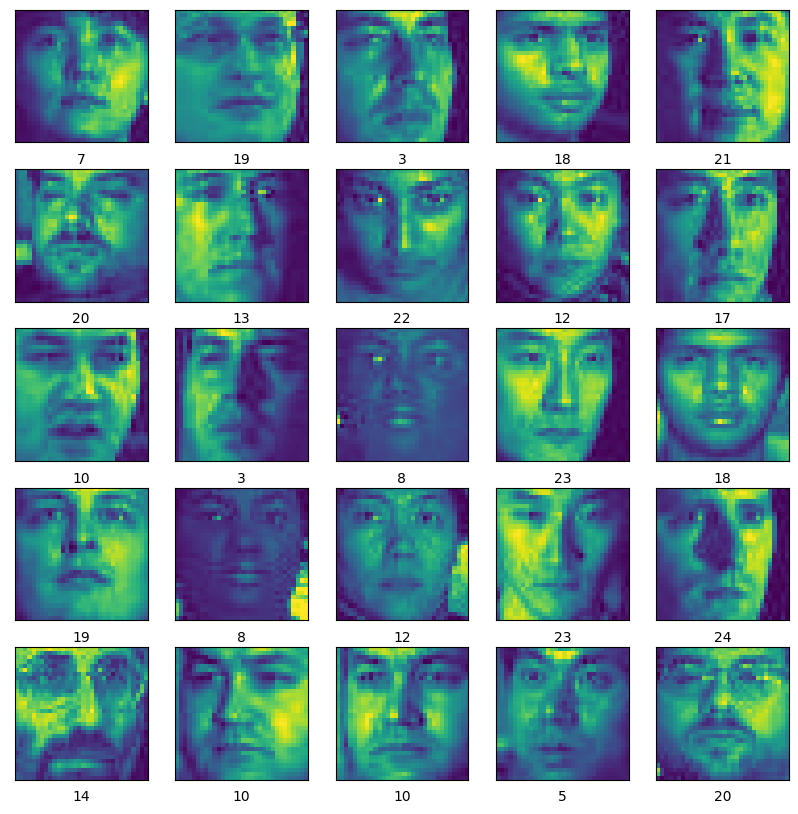

In [15]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

In [16]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32, 1)))
model.add(layers.Conv2D(20, 5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, 5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(26))

2022-11-10 19:20:14.231111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
94/94 [==============================] - 1s 9ms/step - loss: 2.2380 - accuracy: 0.3575
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 0.4313 - accuracy: 0.8831
Epoch 3/10
94/94 [==============================] - 1s 9ms/step - loss: 0.1826 - accuracy: 0.9474
Epoch 4/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0990 - accuracy: 0.9742
Epoch 5/10
94/94 [==============================] - 1s 9ms/step - loss: 0.1075 - accuracy: 0.9685
Epoch 6/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0394 - accuracy: 0.9910
Epoch 7/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0286 - accuracy: 0.9933
Epoch 8/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0227 - accuracy: 0.9943
Epoch 9/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0061 - accuracy: 0.9997
Epoch 10/10
94/94 [==============================] - 1s 9ms/step - loss: 0.0029 - accuracy: 1.0000


In [19]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

40/40 - 0s - loss: 0.0707 - accuracy: 0.9820 - 217ms/epoch - 5ms/step

Test accuracy: 0.9820172190666199


In [20]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

40/40 [==============================] - 0s 3ms/step


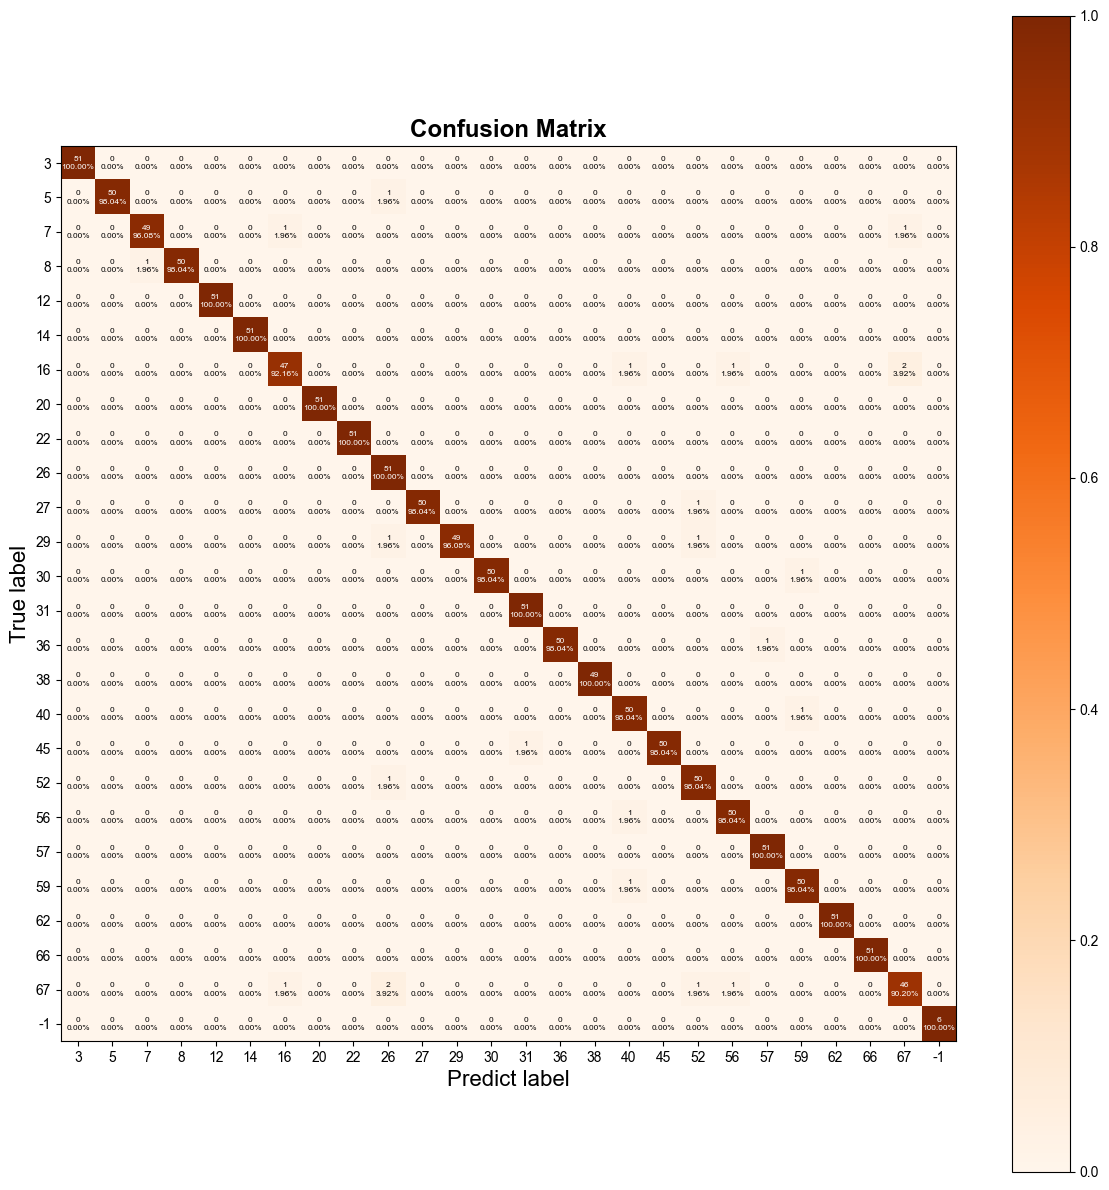

The accuracy of the model is 98.20%
The recall of the model is 99.05%
The precision of the model is 99.13%
The F1 of the model is 99.09%


In [21]:
prelabel(test,predictions,person)

confusion_matrix(test)

_,_,_,_ = score(test)